In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# Load the Data and set up train and test

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'
train_file = data_path + data_prefix + 'classifier_train_data.xlsx'
test_file = data_path + data_prefix + 'classifier_test_data.xlsx'

train = pd.read_excel(train_file, index_col=0)
test = pd.read_excel(test_file, index_col=0)

display(train.head(3))
display(test.head(3))

,target,lag1,roc,rsi,ewma,skew,kurtosis,macd_line,macd_signal,macd_histogram
0,0,-0.026656,0.140818,46.265533,0.047828,0.309292,1.079368,0.000565,-0.000882,0.001447
1,1,-0.004134,0.074442,57.261623,0.045442,0.304377,1.089578,0.002485,0.000868,0.001617
2,0,0.040214,0.068957,72.581668,0.041329,0.305748,1.110621,-0.000416,0.000647,-0.001063


,target,lag1,roc,rsi,ewma,skew,kurtosis,macd_line,macd_signal,macd_histogram
0,0,0.033702,-0.032965,38.716571,0.099559,-0.140854,11.292315,-0.002744,-0.003090,0.000346
1,1,-0.042305,0.040393,62.207613,0.092577,-0.141921,11.286118,0.003178,-0.000351,0.003529
2,0,0.084668,-0.001617,54.223256,0.083020,-0.141565,11.285679,-0.000724,0.000135,-0.000859


In [3]:
features = [col for col in train.columns if col not in 'target']
X_train, y_train, X_val, y_val = train.loc[:, features], train['target'], test.loc[:, features], test['target']
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

## Decision Tree

In [4]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Min Samples Hyperparameter Analysis

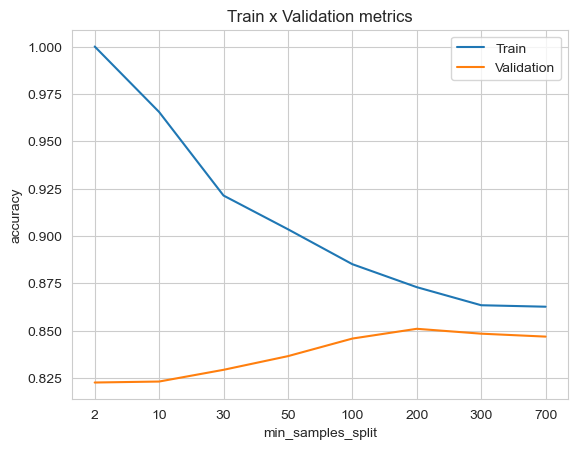

In [5]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

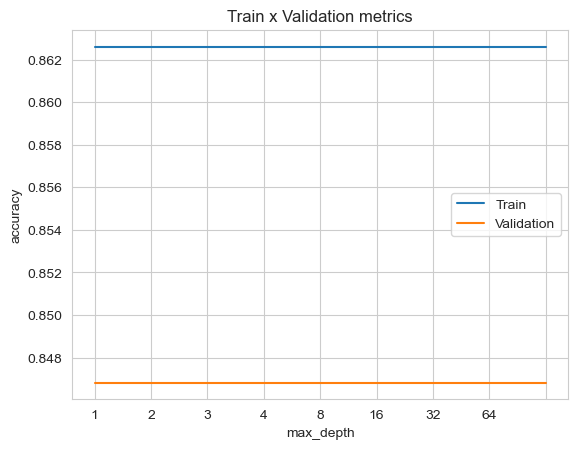

In [6]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [7]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 300,
                                             max_depth = 4,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8577
Metrics validation:
	Accuracy score: 0.8256


## Random Forest

In [8]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

### Min Samples Hyperparameter Analysis

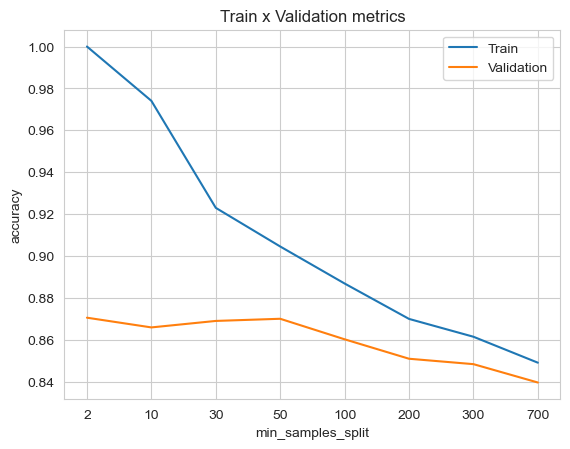

In [9]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

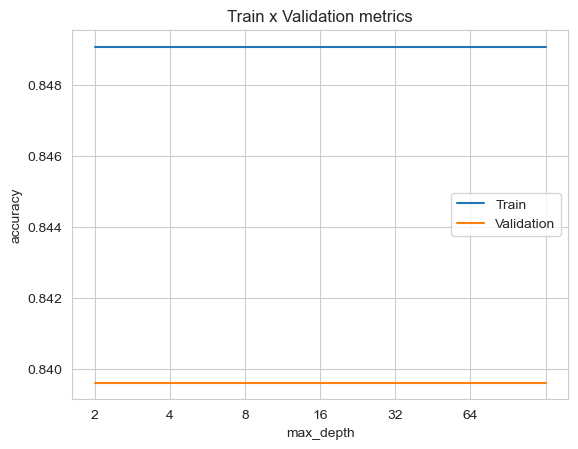

In [10]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### N Estimators Hyperparameter Analysis

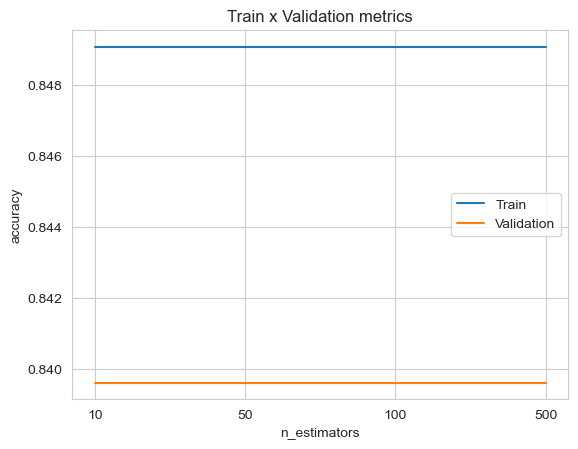

In [11]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [12]:
random_forest_model = RandomForestClassifier(n_estimators = 50,
                                             max_depth = 8, 
                                             min_samples_split = 700).fit(X_train,y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8487
Metrics test:
	Accuracy score: 0.8236


## XGBoost

In [13]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=10)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.63263
[1]	validation_0-logloss:0.58586
[2]	validation_0-logloss:0.54688
[3]	validation_0-logloss:0.51368
[4]	validation_0-logloss:0.48644
[5]	validation_0-logloss:0.46313
[6]	validation_0-logloss:0.44251
[7]	validation_0-logloss:0.42511
[8]	validation_0-logloss:0.40917
[9]	validation_0-logloss:0.39560
[10]	validation_0-logloss:0.38406
[11]	validation_0-logloss:0.37452
[12]	validation_0-logloss:0.36648
[13]	validation_0-logloss:0.35942
[14]	validation_0-logloss:0.35219
[15]	validation_0-logloss:0.34573
[16]	validation_0-logloss:0.33927
[17]	validation_0-logloss:0.33469
[18]	validation_0-logloss:0.32999
[19]	validation_0-logloss:0.32590
[20]	validation_0-logloss:0.32313
[21]	validation_0-logloss:0.32084
[22]	validation_0-logloss:0.31773
[23]	validation_0-logloss:0.31529
[24]	validation_0-logloss:0.31329
[25]	validation_0-logloss:0.31154
[26]	validation_0-logloss:0.30926
[27]	validation_0-logloss:0.30828
[28]	validation_0-logloss:0.30697
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [14]:
xgb_model.best_iteration
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9155
Metrics test:
	Accuracy score: 0.8517


**Testing out Grid Search for Hyperparameter tuning**

In [15]:
# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1]
# }

# # Create the XGBoost model object
# xgb_model = XGBClassifier()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [16]:
# Save the models 
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(random_forest_model, 'random_forest_model.joblib')
joblib.dump(decision_tree_model, 'decision_tree.joblib')

['decision_tree.joblib']